# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
!pip install pretrainedmodels

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

# PATH = "/Users/helen/Desktop/Data/bengaliai-cv19/"
# FEATHER_PATH = "/Users/helen/Desktop/Data/bengaliaicv19feather/"

PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/"
FEATHER_PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliaicv19feather/"

# PATH = "/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/"
# FEATHER_PATH = "/home/vemlr/Work/chen_huang/Data/bengaliaicv19feather/"

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_1.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_0.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_2.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_3.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_2.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_1.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_0.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/sample_submission.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/class_map.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_3.parquet


In [4]:
import torch

debug = False
submission=False
batch_size=96
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out='.'
image_size= 128
arch='pretrained'
model_name='se_resnext101_32x4d'

HEIGHT = 137
WIDTH = 236
# FACTOR = 0.25
# HEIGHT_NEW = int(HEIGHT * FACTOR)
# WIDTH_NEW = int(WIDTH * FACTOR)
WIDTH_NEW = image_size
HEIGHT_NEW = image_size

In [5]:
datadir = Path(PATH)
featherdir = Path(FEATHER_PATH)
LR = 1e-3
WD = 1e-5
DP = 0.3
HDIM = 1024
outdir = Path('{}_2lr_LR{}_WD{}_DP{}_HDIM{}_S{}_autoaug'.format(model_name, LR, WD, DP, HDIM,image_size))

TH = 20.0

In [6]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [7]:
import cv2
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=image_size, pad=3, thh = 80, thl = 28):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > thh)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < thl] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))


In [8]:
import numpy as np
import pandas as pd
import gc


def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype('uint8') for df in image_df_list]

#     images = []
#     for df in image_df_list:
#         for idx in tqdm(range(len(df))):
#             images.append(crop_resize(df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype('uint8')))
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [9]:
%%time

# train = pd.read_csv(datadir/'train.csv')
train = pd.read_csv('train_with_fold.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0,1,2,3] #if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

image_df_list 4
CPU times: user 30.1 s, sys: 30.7 s, total: 1min
Wall time: 6.41 s


In [10]:
print(len(train_labels))
print(len(train))
print(train_labels[200840-1])

200840
200840
[127   2   0]


In [11]:
 import sys 

# These are the usual ipython objects, including this one you are creating 
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars'] 

# Get a sorted list of the objects and their sizes 
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True) 

[('train_images', 6493559008),
 ('train', 39643864),
 ('HTML', 1064),
 ('KFold', 1064),
 ('Path', 896),
 ('filenames', 200),
 ('bbox', 144),
 ('crop_resize', 144),
 ('display', 144),
 ('prepare_image', 144),
 ('datadir', 120),
 ('featherdir', 120),
 ('outdir', 120),
 ('train_labels', 112),
 ('FEATHER_PATH', 104),
 ('indices', 104),
 ('PATH', 98),
 ('dirname', 98),
 ('cb', 88),
 ('ff', 88),
 ('go', 88),
 ('lgb', 88),
 ('np', 88),
 ('pd', 88),
 ('plt', 88),
 ('preprocessing', 88),
 ('px', 88),
 ('sns', 88),
 ('subplots', 88),
 ('tools', 88),
 ('xgb', 88),
 ('filename', 75),
 ('model_name', 68),
 ('arch', 59),
 ('out', 50),
 ('HDIM', 28),
 ('HEIGHT', 28),
 ('HEIGHT_NEW', 28),
 ('WIDTH', 28),
 ('WIDTH_NEW', 28),
 ('batch_size', 28),
 ('image_size', 28),
 ('DP', 24),
 ('LR', 24),
 ('TH', 24),
 ('WD', 24),
 ('debug', 24),
 ('device', 24),
 ('submission', 24)]

<a id="dataset"></a>
# Dataset

In [12]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [13]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

In [14]:
train_dataset_noaug = BengaliAIDataset(train_images[:200], train_labels)

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [15]:
image, label = train_dataset_noaug[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


In [16]:
# print(image[:5,:5])
# print(20/255)

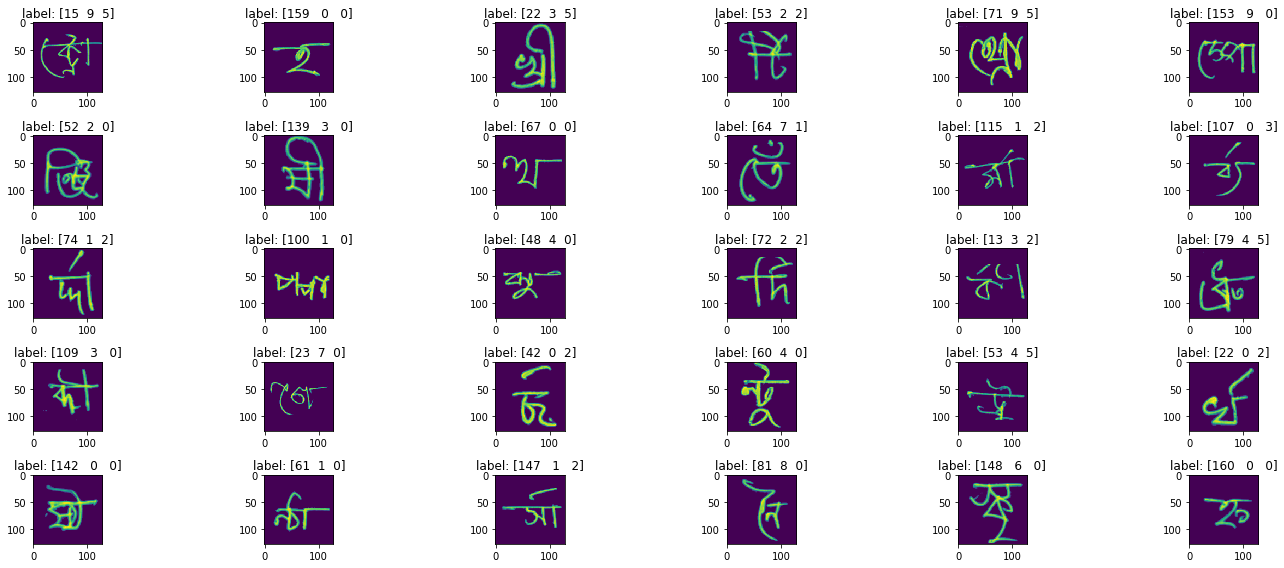

<Figure size 432x288 with 0 Axes>

In [17]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_resize(image, thh = TH/255, thl=28.0/255)) #, cmap='Greys'
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [18]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import SimilarityTransform, AffineTransform, warp
import numpy as np
import math


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.85
    max_scale = 1.15
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 10
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle)*np.pi/180.0

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle)*np.pi/180.0

    # --- translation ---
    max_translation = image_size*0.075
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)
    
#     print("rot:{}, shear:{},tx:{},ty:{}".format(rot_angle,shear_angle, tx,ty))
    
    shape = img.shape
    shape_size = shape[:2]
    center = np.float32(shape_size) / 2.
        
    pre = SimilarityTransform(translation=-center)
    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle, translation=(tx,ty)) 
    after = AffineTransform(translation=center)
    total_transform = pre+tform+after
#     total_transform = tform
    transformed_image = warp(img, total_transform.params, mode='constant')
    
    assert transformed_image.ndim == 2
    return transformed_image

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_char_image_thin(image, threshold=40./255., pad = 16):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def crop_char_image(img0, threshold=TH/255., pad=10):
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > threshold)
    #cropping may cut too much, so we need to add it back
#     xmin = xmin - 5 if (xmin > 5) else 0
#     ymin = ymin - 5 if (ymin > 5) else 0
#     xmax = xmax + 5 if (xmax < WIDTH - 5) else WIDTH
#     ymax = ymax + 5 if (ymax < HEIGHT - 5) else HEIGHT
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28./255.] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return img

# def crop_char_image_new(img0, threshold=TH/255., pad=10):
#     ymin,ymax,xmin,xmax = bbox(img0 > threshold)
#     #cropping may cut too much, so we need to add it back
# #     xmin = xmin - 13 if (xmin > 13) else 0
# #     ymin = ymin - 10 if (ymin > 10) else 0
# #     xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
# #     ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
#     img = img0[ymin:ymax,xmin:xmax]
#     #remove lo intensity pixels as noise
#     img[img < 28./255.] = 0
#     lx, ly = xmax-xmin,ymax-ymin
#     l = max(lx,ly) + pad
#     #make sure that the aspect ratio is kept in rescaling
#     img = np.pad(img, [(pad//2,), (pad//2,)], mode='constant')
#     return img

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

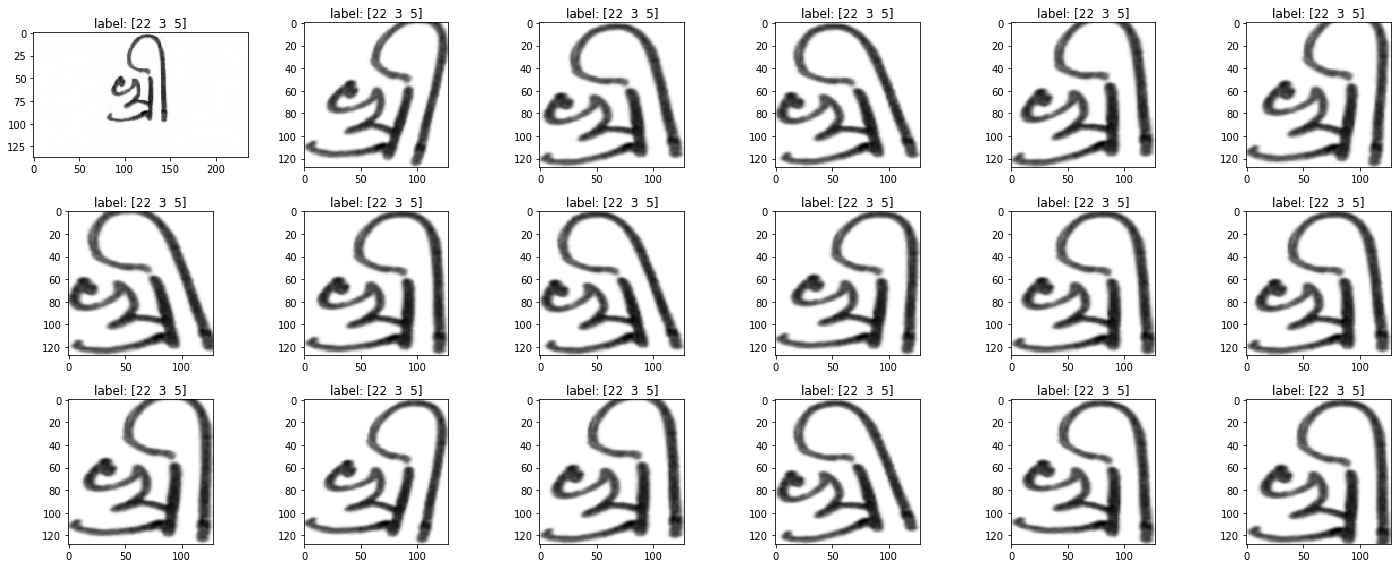

In [19]:
nrow, ncol = 3, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[2]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    else:
        ax.imshow(resize(crop_char_image_thin(affine_image(crop_char_image(image)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
# crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)

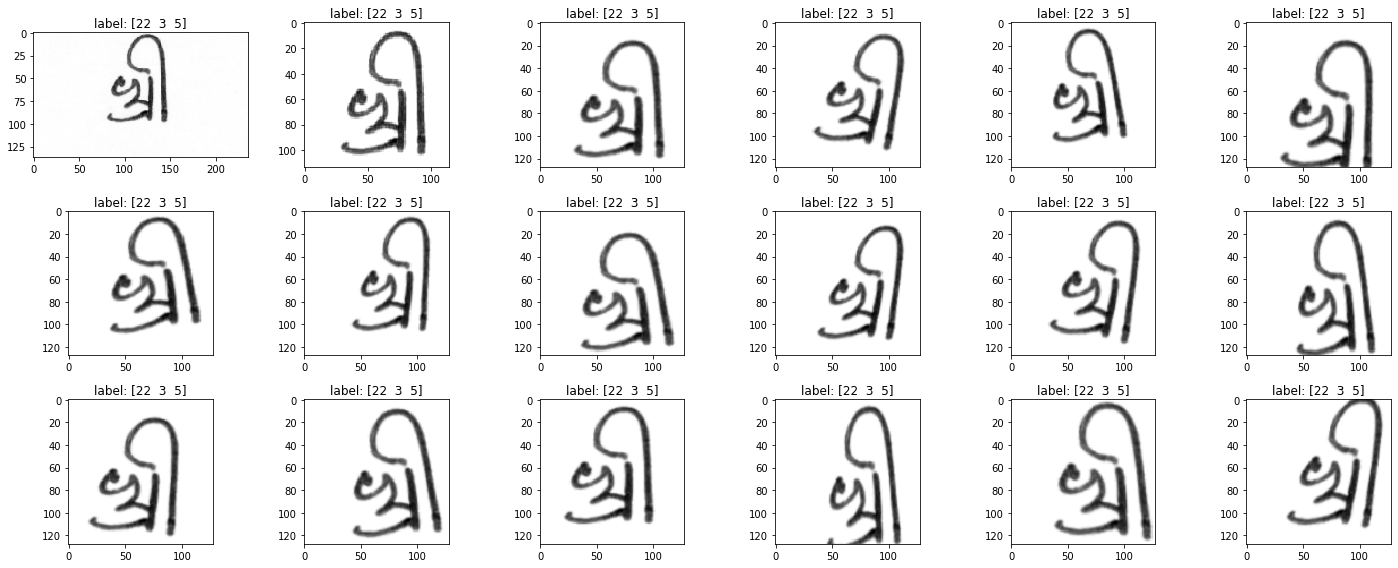

In [20]:
nrow, ncol = 3, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
PAD = 20
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[2]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    elif i==1:
        ax.imshow(crop_char_image(image), cmap='Greys')
    else:
        ax.imshow(resize((affine_image(crop_char_image(image)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

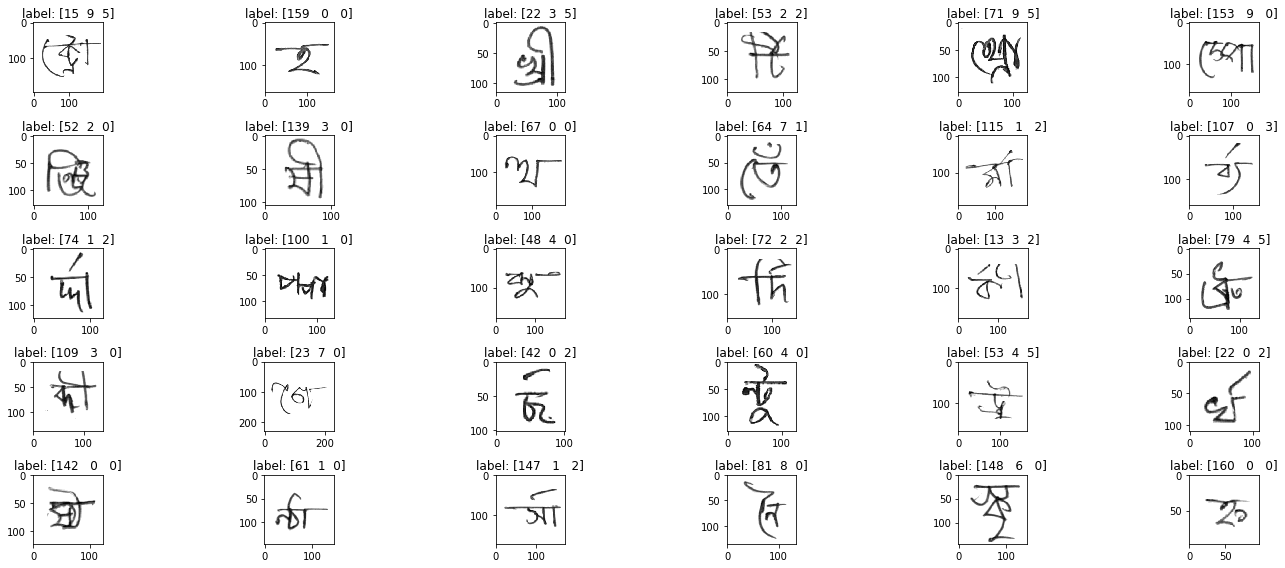

In [21]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_char_image(image, threshold=TH/255.), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

whole process: crop_Char_imgage->affine->crop_char_image_thin->resize

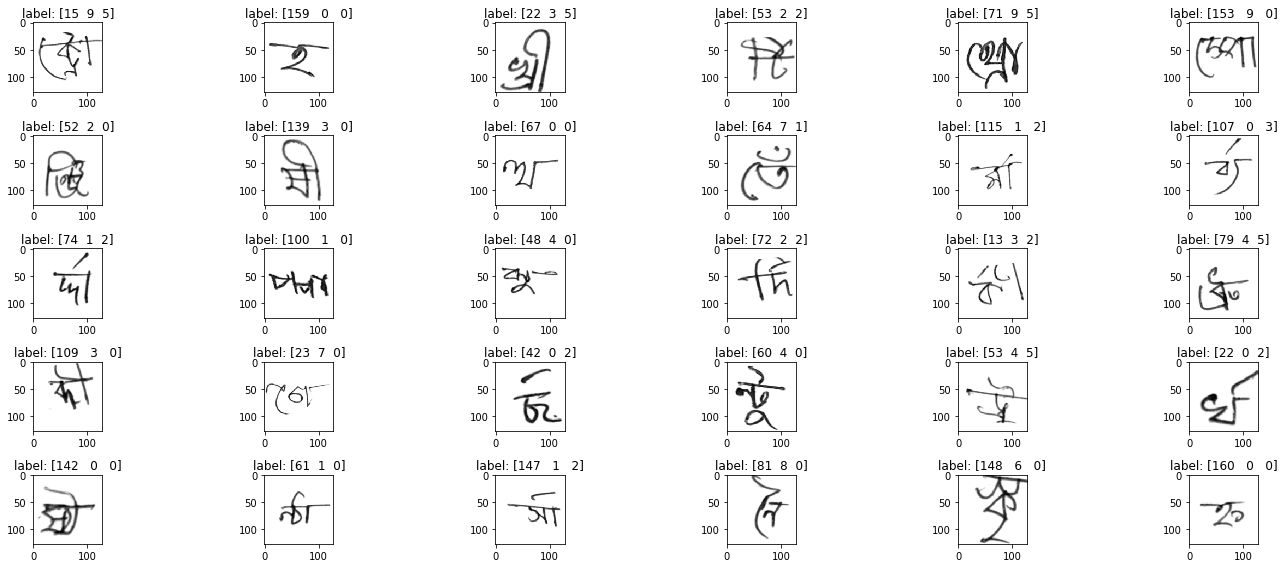

In [22]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(resize((affine_image((crop_char_image(image, threshold=TH/255.))))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [23]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']

class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=TH,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
            
        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
            
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)
            
#         if self.crop:
#             x = crop_char_image_thin(x, threshold=self.threshold)        
            
        if self.size is not None:
            x = resize(x, size=self.size)
            


        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            r = np.random.uniform()
            if r < 0.5:
                x = apply_aug(A.CoarseDropout(max_holes=4, max_height=image_size//8, max_width=image_size//8, p=1.0), x)
            else:
                x = apply_aug(A.Cutout(num_holes=1,  max_h_size=image_size//3, max_w_size=image_size//3, p=1.0),x)  # Deprecated...

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0, mode='constant'), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=10,
                p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if self.normalize:
#             x = (x.astype(np.float32) - 0.0692) / 0.2051  ##ORG
            x = (x.astype(np.float32) - 0.449) / 0.226 ##Imagenet
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x
        


In [24]:
# train_transform = Transform(
#     size=(image_size, image_size), 
#     sigma=-1., blur_ratio=0.2, noise_ratio=0.1, cutout_ratio=0.4,
#     grid_distortion_ratio=0.1, random_brightness_ratio=0.3,
#     piece_affine_ratio=0.2, ssr_ratio=0.2, elastic_distortion_ratio=0.3) #threshold=20.,
# transform = Transform(size=(image_size, image_size)
train_transform = Transform(
    size=(image_size, image_size), cutout_ratio=0.5) #threshold=20.,
train_dataset = BengaliAIDataset(train_images[:200], train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

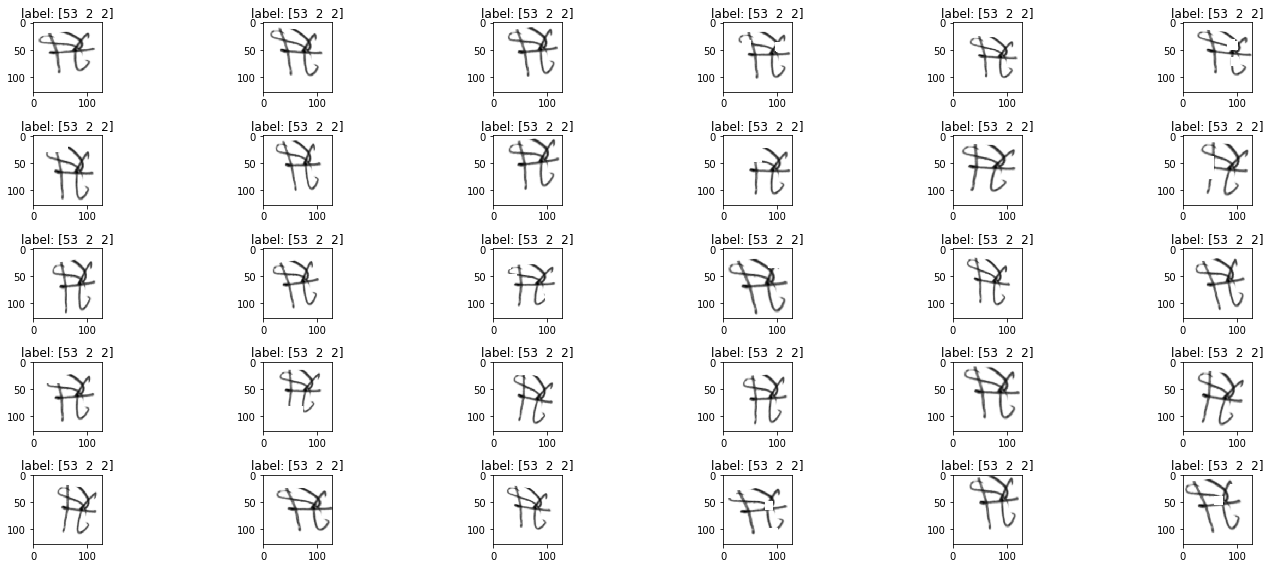

In [25]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[3]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

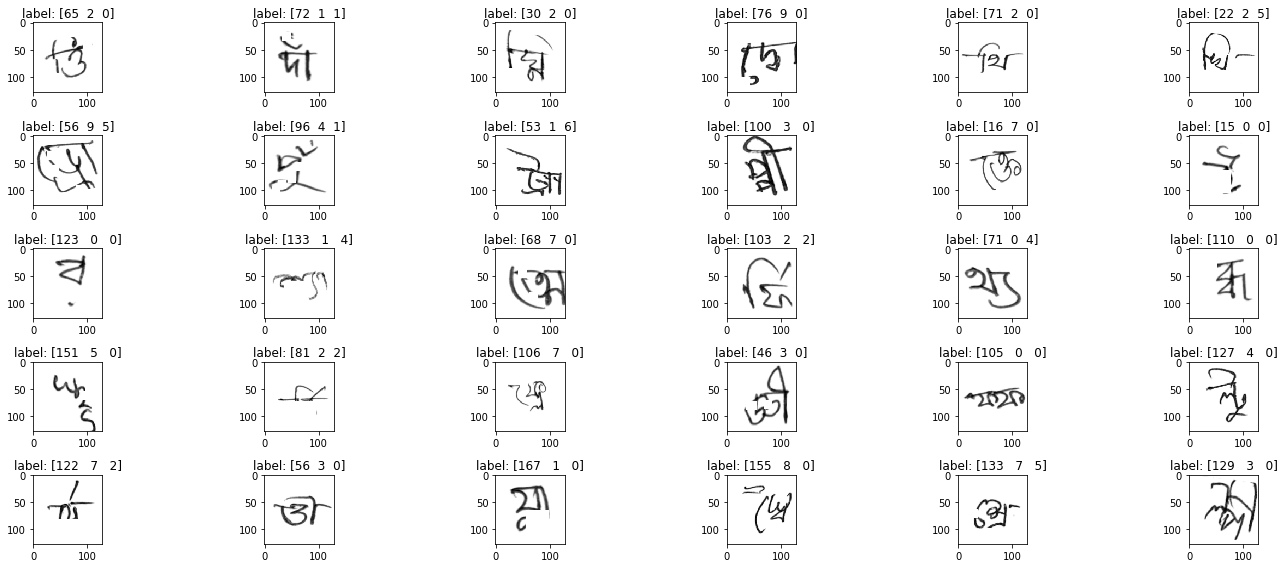

In [26]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i+100]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

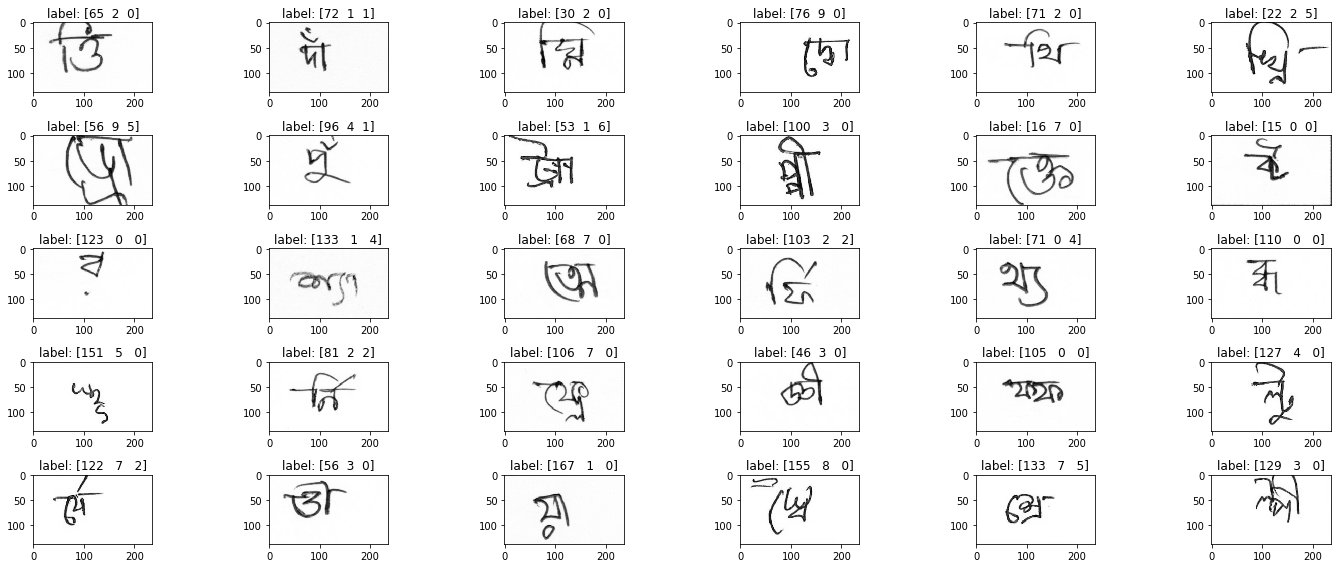

In [27]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i+100]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

In [28]:
%reload_ext autoreload
%autoreload 2

from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import pdb
from autoaugment import ImageNetPolicy, CIFAR10Policy, SVHNPolicy, SubPolicy

In [29]:
import PIL
print("Using Pillow version {}. Upgrade using 'pip install Pillow -U'".format(PIL.__version__))

Using Pillow version 6.2.1. Upgrade using 'pip install Pillow -U'


In [30]:
def show_sixteen(images, titles=0):
    f, axarr = plt.subplots(4, 4, figsize=(15, 15), gridspec_kw={"wspace": 0, "hspace": 0})
    for idx, ax in enumerate(f.axes):
        ax.imshow(images[idx])
        ax.axis("off")
        if titles: ax.set_title(titles[idx])
    plt.show()

In [31]:
# auto_transform=transforms.Compose(
#                         [transforms.Resize(image_size), 
#                          SVHNPolicy(), 
#                          transforms.ToTensor(),
#                          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
#                         ])

In [32]:
class AutoTransform:
    def __init__(self, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=TH,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., 
                 piece_affine_ratio=0., auto_aug=False):
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.auto_policy = SVHNPolicy()
        self.auto_aug = auto_aug

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
            
        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
            
#         if self.crop:
#             x = crop_char_image_thin(x, threshold=self.threshold)

        if self.size is not None:
            x = resize(x, size=self.size)
            
        x = np.transpose(np.stack((x, x, x), axis=0),(1,2,0))
        
        if self.auto_aug:
            x_int = Image.fromarray((x*255).astype(np.uint8))
            x_int = self.auto_policy(x_int)
            x = numpy.asarray(x_int).astype(np.float32) / 255.
            if np.mean(x)>0.5:
                x = 1-x
        
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
#         assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            r = np.random.uniform()
            if r < 0.5:
                x = apply_aug(A.CoarseDropout(max_holes=4, max_height=HEIGHT_NEW//8, max_width=WIDTH_NEW//8, p=1.0), x)
            else:
                x = apply_aug(A.Cutout(num_holes=1,  max_h_size=HEIGHT_NEW//3, max_w_size=WIDTH_NEW//3, p=1.0),x)  # Deprecated...

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)


        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0, mode='constant'), x)


        if self.normalize:
#             x = (x.astype(np.float32) - 0.0692) / 0.2051  ##ORG
            x = (x.astype(np.float32) - 0.449) / 0.226 ##Imagenet
#         if x.ndim == 2:
#             x = x[None, :, :]
        x = x.astype(np.float32)
        x = np.transpose(x,(2,0,1))
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [33]:
train_auto_transform = AutoTransform(auto_aug=True, crop = True,
    size=(WIDTH_NEW, HEIGHT_NEW), cutout_ratio=0.5) #threshold=20.,
train_auto_dataset = BengaliAIDataset(train_images[:200], train_labels,
                                 transform=train_auto_transform)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

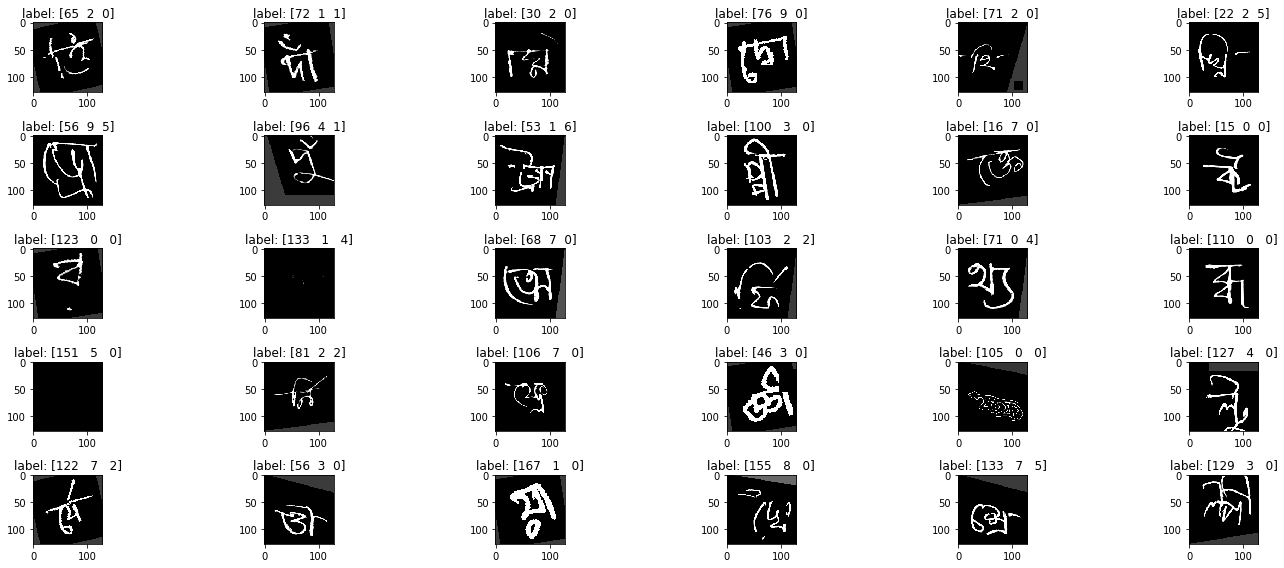

In [34]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_auto_dataset[i+100]
    ax.imshow(np.transpose(image,(1,2,0)), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

In [35]:
image, label = train_auto_dataset[i+100]
print(np.max(image))
print(np.min(image))

2.177772
-1.9867257


<a id="model"></a> 
# pytorch model & define classifier

In [36]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [37]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [38]:
a = np.array([2,3])
b = np.array([4,5,6])

In [39]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [40]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [41]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class ClassifierNew(nn.Module):
    def __init__(self, inp = 2048, h1=1024, out = 1000, dropout_ratio=0.35):
        super().__init__()
        self.ap = nn.AdaptiveAvgPool2d(1)
        self.mp = nn.AdaptiveMaxPool2d(1)
        self.fla = Flatten()
        self.bn0 = nn.BatchNorm1d(inp*2,eps=1e-05, momentum=0.1, affine=True)
        self.dropout0 = nn.Dropout(dropout_ratio)
        self.fc1 = nn.Linear(inp*2, h1)
        self.bn1 = nn.BatchNorm1d(h1,eps=1e-05, momentum=0.1, affine=True)
        self.dropout1 = nn.Dropout(dropout_ratio)
        self.fc2 = nn.Linear(h1, out)
        
    def forward(self, x):
        ap = self.ap(x)
        mp = self.mp(x)
        x = torch.cat((ap,mp),dim=1)
        x = self.fla(x)
        x = self.bn0(x)
        x = self.dropout0(x)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)         
        x = self.fc2(x)
        return x

In [42]:
# ap = nn.AdaptiveAvgPool2d((1,1))
# mp = nn.AdaptiveMaxPool2d((1,1))
# x = np.random.rand(5,4,4)
# print(x)
# print(ap)
# x1 = torch.nn.functional.adaptive_avg_pool2d(x, (1,1))
# print(x1)

In [43]:
a = torch.Tensor([[1,2],[3,4]])
b = torch.sum(a,dim=(-1,-2))
print(b)

tensor(10.)


In [44]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [45]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
import collections
try:
    from collections import OrderedDict
except ImportError:
    OrderedDict = dict

class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext101_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet', dropout_ratio=0):
        super(PretrainedCNN, self).__init__()
#         self.conv0 = nn.Conv2d(
#             in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
#         print(self.base_model)
#         names = []
#         for name, child in self.base_model.named_children():
#             names.append(name)
            
#         arch = self.base_model
#         arch = list(arch.children())
#         #saving the weights of the forst conv in w
#         w = arch[0][0].weight
#         #creating new Conv2d to accept 1 channel 
#         arch[0][0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         #substituting weights of newly created Conv2d with w from but we have to take mean
#         #to go from  3 channel to 1
#         arch[0][0].weight = nn.Parameter(torch.mean(w, dim=1, keepdim=True))
#         arch = nn.Sequential(OrderedDict([(names[k], arch[k]) for k in range(len(names))]))
# #         print(arch)
#         self.base_model = arch
#         print("#######################################")
#         print(self.base_model)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        
        hdim = HDIM
        self.classifer = ClassifierNew(inp = inch, h1=hdim, out = out_dim, dropout_ratio=dropout_ratio)
#         lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
#         lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
#         self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        h = self.base_model.layer0(x)
        h = self.base_model.layer1(h)
        h = self.base_model.layer2(h)
        h = self.base_model.layer3(h)
        h = self.base_model.layer4(h)
        
        h = self.classifer(h)

        return h

In [46]:
def print_base_layers(predictor):
    print("base model layer names::")
    for name, child in predictor.base_model.named_children():
        print(name)
        
def print_base_grad_status(predictor):
    print("base model grad status::")
    for name, child in predictor.base_model.named_children():
        print(name)
        for param in child.parameters():
            print(param.requires_grad)

In [47]:
# print_grad_status(predictortmp)

In [48]:
def frozen_basiclayers(predictor):
    for name, child in predictor.base_model.named_children():
        if name in ['layer0','layer1','layer2','layer3']:
            print(name + ' is frozen')
            for param in child.parameters():
                param.requires_grad = False
        else:
            print(name + ' is unfrozen')
            for param in child.parameters():
                param.requires_grad = True

In [49]:
def unfrozen_basiclayers(predictor):
    for name, child in predictor.base_model.named_children():
        for param in child.parameters():
            param.requires_grad = True

In [50]:
# frozen_basiclayers(predictortmp)
# print_grad_status(predictortmp)

In [51]:
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

n_total 186


In [52]:
predictortmp = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained="imagenet")
for name, child in predictortmp.named_children():
    print(name)
print_base_layers(predictortmp)

base_model
classifer
base model layer names::
layer0
layer1
layer2
layer3
layer4
avg_pool
last_linear


In [53]:
# def get_optimizer_adam(classifier, learning_rate=1e-3, weight_decay=0.0):
    
#     base_params = list(map(id, classifier.predictor.base_model.parameters()))
#     fast_learned_params = filter(lambda p: id(p) not in base_params, 
#                                  classifier.parameters())
# #     print("base_params len:", len(base_params))
# #     print("fast_learned_params len:", len(list(fast_learned_params)))
#     lr_100 = max(learning_rate/100, 1e-6)
#     lr_10 = max(learning_rate/10, 5e-6)
#     optimizer = torch.optim.Adam(
#     [
#         dict(params=classifier.predictor.base_model.layer0.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer1.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer2.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer3.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer4.parameters(), lr=lr_10),        
#         dict(params=classifier.predictor.base_model.avg_pool.parameters(), lr=lr_10),
#         dict(params=classifier.predictor.base_model.last_linear.parameters(), lr=lr_10),
#         {'params': fast_learned_params},
#     ], lr = learning_rate, weight_decay=weight_decay)
    
#     return optimizer

In [54]:
def get_optimizer_adam(classifier, learning_rate=1e-3, weight_decay=0.0):
    
    base_params = list(map(id, classifier.predictor.base_model.parameters()))
    fast_learned_params = filter(lambda p: id(p) not in base_params, 
                                 classifier.parameters())
#     print("base_params len:", len(base_params))
#     print("fast_learned_params len:", len(list(fast_learned_params)))
    lr_100 = max(learning_rate/100, 1e-7)
    lr_10 = max(learning_rate/10, 1e-7)
    optimizer = torch.optim.Adam(
    [
        dict(params=classifier.predictor.base_model.layer0.parameters(), lr=lr_10),
        dict(params=classifier.predictor.base_model.layer1.parameters(), lr=lr_10),
        dict(params=classifier.predictor.base_model.layer2.parameters(), lr=lr_10),
        dict(params=classifier.predictor.base_model.layer3.parameters(), lr=lr_10),
        dict(params=classifier.predictor.base_model.layer4.parameters(), lr=learning_rate),        
        dict(params=classifier.predictor.base_model.avg_pool.parameters(), lr=learning_rate),
        dict(params=classifier.predictor.base_model.last_linear.parameters(), lr=learning_rate),
        {'params': fast_learned_params},
    ], lr = learning_rate, weight_decay=weight_decay)
    
    return optimizer

## Classifier

In [55]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    if isinstance(acc, torch.Tensor):
        acc = acc.item()
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = 2*F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


In [56]:
# classifiertmp = BengaliClassifier(predictortmp).to(device)
# # for name, child in classifiertmp.named_children():
# #     print(name)
# # optimizertmp = get_optimizer_adam(classifiertmp)
# # print(optimizertmp)

# ctmp_params = list(map(id, classifiertmp.parameters()))
# print(len(ctmp_params))

# pbtmp_params = list(map(id, predictortmp.base_model.parameters()))
# print(len(pbtmp_params))

# pcftmp_params = list(map(id, predictortmp.classifer.parameters()))
# print(len(pcftmp_params))

# opt_tmp = get_optimizer_adam(classifiertmp)
# print(opt_tmp)

<a id="train"></a>
# Training code


In [57]:
# --- Model ---
device = torch.device(device)

def schedule_lr(metrics):
    avg_mae = metrics['loss']
    # --- update lr ---
    lr = scheduler.optimizer.param_groups[-1]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

## prepare data

In [58]:
from logging import getLogger
import numpy
import os
from time import perf_counter
import argparse
from distutils.util import strtobool
import torch
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

import pandas as pd
import torch
import json


def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


In [59]:
class LogReport:
    def __init__(self, dirpath=None, logger=None):
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, epoch, iteration, train_metrics, val_metrics, mode):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': epoch,
                'iteration': iteration}
        
        elem.update({f'train/{key}': value
                     for key, value in train_metrics.items()})
        
        elem.update({f'val/{key}': value
             for key, value in val_metrics.items()})
        
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
#         print("mode in log type:{}, val:{}".format(type(mode), mode))
        elem['mode'] = str(mode)
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            elif isinstance(value, str):
                msg += f'{key} {value} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df

In [60]:
class ModelSnapshotHandler:
    def __init__(self, model, filepath='model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self):
        self.count += 1
        filepath = self.filepath.format(count=self.count)
        torch.save(self.model.state_dict(), filepath)

In [61]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [62]:
loss_recall_names =  ['loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant', 'recall']

In [63]:
def train_model(epoch, data_loader, log_report, n_train_call):
    classifier.train()
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    n_tag = 0
    for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
        n_sub = img_batch.shape[0]
        img_batch = img_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        loss, metrics, pred_y = classifier(img_batch, regr_batch)
        
        recall = macro_recall(pred_y, regr_batch)
        metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
        for key, val in metrics.items():
                metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)
                
        n_tag = n_tag + n_sub
        n_train_call[0] += n_sub
        
        loss.backward()
        optimizer.step()
        
    return metrics_total, n_train_call

In [64]:
def evaluate_model(epoch, data_loader, log_report):
    classifier.eval()
    n_tag = 0
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    with torch.no_grad():
        for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
            n_sub = img_batch.shape[0]
            img_batch = img_batch.to(device)
            regr_batch = regr_batch.to(device)

            _, metrics, pred_y = classifier(img_batch, regr_batch)
        
            recall = macro_recall(pred_y, regr_batch)
            metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
            for key, val in metrics.items():
                    metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)

            n_tag = n_tag + n_sub
        
        schedule_lr(metrics_total)   
        return metrics_total


## Train


In [65]:
def save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall, outdir):
    mode = list("000")
    if((epoch+1)%10==0):
        model_file_name = os.path.join(outdir, 'predictor_{}_{}.pt'.format(l1,epoch))
        torch.save(predictor.state_dict(), model_file_name)
        mode[0] = "1"
    if(val_metrics['loss']<min_val_loss):
        min_val_loss = val_metrics['loss']
        if mode[0] is "0":
            model_file_name = os.path.join(outdir, 'predictor_min_loss.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[1] = "1"
    if(val_metrics['recall']>max_val_recall):
        max_val_recall = val_metrics['recall']
        if mode[0] is not "1" and mode[1] is not "1":
            model_file_name = os.path.join(outdir, 'predictor_max_recall.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[2] = "1"
    mode = ''.join(mode)
    return mode, min_val_loss, max_val_recall

In [66]:
def save_params(outdir, k, img_size, th, arch, batchsize):
    save_json(os.path.join(outdir, 'args_{}.json'.format(k)), 
              {'image_size': img_size, 
               'threshold': th, 
               'batch_size':batchsize,
               'arch': arch, 
               'model_name': model_name,
               'learning_rate': LR,
               'weight_decay': WD,
               'dropout_ratio': DP,
               'hidden_dim':HDIM
              }
             )

In [67]:
def save_checkpoint(epochID, model, optimizer, scheduler, accMax, lossMIN, checkpoint_path, launchTimestamp):
    torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'max_recall': accMax, 'loss_min': lossMIN,
                            'optimizer': optimizer.state_dict(), 'scheduler':scheduler.state_dict()},
                           checkpoint_path + '/m-checkpoint.pth.tar')
#      launchTimestamp + '-' + str("%.4f" % lossMIN) +
    
def load_checkpoint(model, checkpoint_path, optimizer):
    if checkpoint_path != None:
        checkpoint_path += '/m-checkpoint.pth.tar'
        model_CKPT = torch.load(checkpoint_path)
        model.load_state_dict(model_CKPT['state_dict'])
        print('loading checkpoint!')
        optimizer.load_state_dict(model_CKPT['optimizer'])
        epoch = model_CKPT['epoch']
        acc_Max = model_CKPT['max_recall']
        loss_MIN = model_CKPT['loss_min']
        scheduler.load_state_dict(model_CKPT['scheduler'])
    return epoch, model, optimizer, scheduler, acc_Max, loss_MIN

In [ ]:
import gc

train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
n_epochs = 150
kfold = 5
if not os.path.exists(outdir):
    os.mkdir(outdir)
for k in range(kfold):
    # Set pretrained='imagenet' to download imagenet pretrained model...
    predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained="imagenet", dropout_ratio=DP)
    print('predictor', type(predictor))
    start_time = perf_counter()
    classifier = BengaliClassifier(predictor).to(device)
    # --- Training setting ---
#     optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4, weight_decay=3e-4)
    optimizer = get_optimizer_adam(classifier, learning_rate=LR, weight_decay=WD)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-7)

    sub_dir = os.path.join(outdir,"{}_fold".format(k))
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)
    log_report = LogReport(dirpath=sub_dir)
    n_train_call = [0]
    min_val_loss = 1e10
    max_val_recall = 0
    val_indexes = train[train['fold']==k].index.tolist()
    train_indexes = train[train['fold']!=k].index.tolist()
    save_params(outdir, k, image_size, TH, arch, batch_size)
    if debug:
        val_indexes = val_indexes[:100]
        train_indexes = train_indexes[:200]
        print("val_indexes:", val_indexes[:5])
        print("train_indexes:", train_indexes[:5])
        
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=train_auto_transform,
        indices=train_indexes)
    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=AutoTransform(crop = True, size=(WIDTH_NEW, HEIGHT_NEW)),
        indices=val_indexes)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        gc.collect()
        train_metrics, n_train_call = train_model(epoch, train_loader, log_report, n_train_call)
        val_metrics = evaluate_model(epoch, valid_loader, log_report)
        mode, min_val_loss, max_val_recall = save_res(predictor, k, epoch, val_metrics, min_val_loss, 
                                                      max_val_recall, sub_dir)
        save_checkpoint(epoch, predictor, optimizer, scheduler, max_val_recall, min_val_loss, sub_dir, 
                                str(int(perf_counter()- start_time)))
#         print("mode type:{}, mode val:{}".format(type(mode), mode))
#         print("min_val_loss = ", min_val_loss)
#         print("max_val_recall = ", max_val_recall)
        log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)
    
    model_file_name = os.path.join(sub_dir, 'predictor_{}_{}.pt'.format(k,epoch))
    torch.save(predictor.state_dict(), model_file_name)

predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/1674 [00:00<?, ?it/s]/home/chen/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      0 train/loss  2.790305 train/loss_grapheme  2.170545 train/loss_vowel  0.339608 train/loss_consonant  0.280152 train/acc_grapheme  0.720182 train/acc_vowel  0.894250 train/acc_consonant  0.913271 train/recall  0.739753 val/loss  0.776011 val/loss_grapheme  0.598629 val/loss_vowel  0.090333 val/loss_consonant  0.087050 val/acc_grapheme  0.912841 val/acc_vowel  0.974656 val/acc_consonant  0.974183 val/recall  0.911291 lr  0.001000 elapsed_time  1873.291213 mode 011 


100%|██████████| 419/419 [02:45<00:00,  2.54it/s]


epoch      1 train/loss  1.210715 train/loss_grapheme  0.915930 train/loss_vowel  0.154830 train/loss_consonant  0.139955 train/acc_grapheme  0.869199 train/acc_vowel  0.954348 train/acc_consonant  0.956881 train/recall  0.865332 val/loss  0.647031 val/loss_grapheme  0.503617 val/loss_vowel  0.071999 val/loss_consonant  0.071415 val/acc_grapheme  0.929845 val/acc_vowel  0.980457 val/acc_consonant  0.979860 val/recall  0.926615 lr  0.001000 elapsed_time  3760.105261 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      2 train/loss  0.990341 train/loss_grapheme  0.746122 train/loss_vowel  0.126967 train/loss_consonant  0.117252 train/acc_grapheme  0.892912 train/acc_vowel  0.963005 train/acc_consonant  0.964499 train/recall  0.888700 val/loss  0.563715 val/loss_grapheme  0.431031 val/loss_vowel  0.065028 val/loss_consonant  0.067656 val/acc_grapheme  0.936069 val/acc_vowel  0.982598 val/acc_consonant  0.980034 val/recall  0.933039 lr  0.001000 elapsed_time  5652.087343 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      3 train/loss  0.850779 train/loss_grapheme  0.634771 train/loss_vowel  0.113195 train/loss_consonant  0.102813 train/acc_grapheme  0.908677 train/acc_vowel  0.967443 train/acc_consonant  0.969080 train/recall  0.903702 val/loss  0.538064 val/loss_grapheme  0.410718 val/loss_vowel  0.063430 val/loss_consonant  0.063916 val/acc_grapheme  0.942267 val/acc_vowel  0.983569 val/acc_consonant  0.981851 val/recall  0.939110 lr  0.001000 elapsed_time  7533.409286 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      4 train/loss  0.775539 train/loss_grapheme  0.579323 train/loss_vowel  0.102264 train/loss_consonant  0.093951 train/acc_grapheme  0.916438 train/acc_vowel  0.969945 train/acc_consonant  0.971663 train/recall  0.911267 val/loss  0.490402 val/loss_grapheme  0.375092 val/loss_vowel  0.058575 val/loss_consonant  0.056736 val/acc_grapheme  0.946201 val/acc_vowel  0.985610 val/acc_consonant  0.983843 val/recall  0.943509 lr  0.001000 elapsed_time  9396.886344 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      5 train/loss  0.711132 train/loss_grapheme  0.526331 train/loss_vowel  0.095320 train/loss_consonant  0.089481 train/acc_grapheme  0.923583 train/acc_vowel  0.972329 train/acc_consonant  0.973175 train/recall  0.917346 val/loss  0.481578 val/loss_grapheme  0.364474 val/loss_vowel  0.060147 val/loss_consonant  0.056958 val/acc_grapheme  0.949039 val/acc_vowel  0.984739 val/acc_consonant  0.984216 val/recall  0.946573 lr  0.001000 elapsed_time  11272.831798 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      6 train/loss  0.666761 train/loss_grapheme  0.494759 train/loss_vowel  0.088978 train/loss_consonant  0.083024 train/acc_grapheme  0.928121 train/acc_vowel  0.974414 train/acc_consonant  0.975030 train/recall  0.922393 val/loss  0.491961 val/loss_grapheme  0.379120 val/loss_vowel  0.056433 val/loss_consonant  0.056408 val/acc_grapheme  0.947819 val/acc_vowel  0.985785 val/acc_consonant  0.985212 val/recall  0.945596 lr  0.001000 elapsed_time  13151.864836 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      7 train/loss  0.620019 train/loss_grapheme  0.457284 train/loss_vowel  0.083899 train/loss_consonant  0.078835 train/acc_grapheme  0.932782 train/acc_vowel  0.975845 train/acc_consonant  0.976897 train/recall  0.927789 val/loss  0.454951 val/loss_grapheme  0.349956 val/loss_vowel  0.051971 val/loss_consonant  0.053024 val/acc_grapheme  0.951852 val/acc_vowel  0.987254 val/acc_consonant  0.985063 val/recall  0.948869 lr  0.001000 elapsed_time  15048.622307 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      8 train/loss  0.582599 train/loss_grapheme  0.427658 train/loss_vowel  0.079052 train/loss_consonant  0.075890 train/acc_grapheme  0.936884 train/acc_vowel  0.977115 train/acc_consonant  0.976990 train/recall  0.931167 val/loss  0.456738 val/loss_grapheme  0.346499 val/loss_vowel  0.054974 val/loss_consonant  0.055266 val/acc_grapheme  0.951927 val/acc_vowel  0.986656 val/acc_consonant  0.985237 val/recall  0.949201 lr  0.001000 elapsed_time  16943.496978 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      9 train/loss  0.558279 train/loss_grapheme  0.409403 train/loss_vowel  0.076927 train/loss_consonant  0.071949 train/acc_grapheme  0.939641 train/acc_vowel  0.977812 train/acc_consonant  0.978434 train/recall  0.934140 val/loss  0.462112 val/loss_grapheme  0.352326 val/loss_vowel  0.054997 val/loss_consonant  0.054789 val/acc_grapheme  0.951977 val/acc_vowel  0.986855 val/acc_consonant  0.985287 val/recall  0.950111 lr  0.001000 elapsed_time  18839.907728 mode 101 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     10 train/loss  0.528734 train/loss_grapheme  0.389125 train/loss_vowel  0.071204 train/loss_consonant  0.068405 train/acc_grapheme  0.942653 train/acc_vowel  0.979642 train/acc_consonant  0.979592 train/recall  0.937717 val/loss  0.467753 val/loss_grapheme  0.359745 val/loss_vowel  0.054251 val/loss_consonant  0.053757 val/acc_grapheme  0.953097 val/acc_vowel  0.986880 val/acc_consonant  0.985835 val/recall  0.952033 lr  0.001000 elapsed_time  20727.998601 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     11 train/loss  0.502708 train/loss_grapheme  0.365738 train/loss_vowel  0.070663 train/loss_consonant  0.066307 train/acc_grapheme  0.945516 train/acc_vowel  0.979878 train/acc_consonant  0.980189 train/recall  0.940337 val/loss  0.447467 val/loss_grapheme  0.339665 val/loss_vowel  0.054867 val/loss_consonant  0.052936 val/acc_grapheme  0.954392 val/acc_vowel  0.987079 val/acc_consonant  0.985536 val/recall  0.951564 lr  0.001000 elapsed_time  22616.148195 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     12 train/loss  0.494297 train/loss_grapheme  0.362683 train/loss_vowel  0.067691 train/loss_consonant  0.063923 train/acc_grapheme  0.946419 train/acc_vowel  0.980544 train/acc_consonant  0.980737 train/recall  0.941695 val/loss  0.435181 val/loss_grapheme  0.329819 val/loss_vowel  0.052979 val/loss_consonant  0.052383 val/acc_grapheme  0.956607 val/acc_vowel  0.986855 val/acc_consonant  0.986034 val/recall  0.952850 lr  0.001000 elapsed_time  24504.506670 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     13 train/loss  0.469003 train/loss_grapheme  0.340961 train/loss_vowel  0.064727 train/loss_consonant  0.063316 train/acc_grapheme  0.949811 train/acc_vowel  0.981540 train/acc_consonant  0.981440 train/recall  0.945006 val/loss  0.470291 val/loss_grapheme  0.363040 val/loss_vowel  0.053259 val/loss_consonant  0.053991 val/acc_grapheme  0.953296 val/acc_vowel  0.987378 val/acc_consonant  0.986034 val/recall  0.951646 lr  0.001000 elapsed_time  26394.650772 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     14 train/loss  0.453825 train/loss_grapheme  0.330661 train/loss_vowel  0.063623 train/loss_consonant  0.059541 train/acc_grapheme  0.951062 train/acc_vowel  0.981758 train/acc_consonant  0.982094 train/recall  0.945998 val/loss  0.457362 val/loss_grapheme  0.350938 val/loss_vowel  0.054623 val/loss_consonant  0.051801 val/acc_grapheme  0.956184 val/acc_vowel  0.987677 val/acc_consonant  0.986781 val/recall  0.953549 lr  0.001000 elapsed_time  28283.434944 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     15 train/loss  0.444165 train/loss_grapheme  0.321367 train/loss_vowel  0.062190 train/loss_consonant  0.060609 train/acc_grapheme  0.952319 train/acc_vowel  0.981957 train/acc_consonant  0.981801 train/recall  0.947040 val/loss  0.466970 val/loss_grapheme  0.364207 val/loss_vowel  0.050850 val/loss_consonant  0.051913 val/acc_grapheme  0.953495 val/acc_vowel  0.988374 val/acc_consonant  0.986581 val/recall  0.951791 lr  0.001000 elapsed_time  30175.771058 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     16 train/loss  0.432291 train/loss_grapheme  0.315308 train/loss_vowel  0.059625 train/loss_consonant  0.057358 train/acc_grapheme  0.952780 train/acc_vowel  0.982866 train/acc_consonant  0.983077 train/recall  0.948698 val/loss  0.467123 val/loss_grapheme  0.355979 val/loss_vowel  0.054552 val/loss_consonant  0.056592 val/acc_grapheme  0.954093 val/acc_vowel  0.987702 val/acc_consonant  0.985959 val/recall  0.951694 lr  0.001000 elapsed_time  32069.417259 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     17 train/loss  0.410963 train/loss_grapheme  0.298396 train/loss_vowel  0.057531 train/loss_consonant  0.055036 train/acc_grapheme  0.955543 train/acc_vowel  0.983314 train/acc_consonant  0.983339 train/recall  0.951246 val/loss  0.448065 val/loss_grapheme  0.343455 val/loss_vowel  0.050930 val/loss_consonant  0.053680 val/acc_grapheme  0.956856 val/acc_vowel  0.988473 val/acc_consonant  0.985835 val/recall  0.953670 lr  0.001000 elapsed_time  33955.219005 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     18 train/loss  0.406540 train/loss_grapheme  0.294866 train/loss_vowel  0.056148 train/loss_consonant  0.055526 train/acc_grapheme  0.956701 train/acc_vowel  0.983918 train/acc_consonant  0.983277 train/recall  0.952081 val/loss  0.490633 val/loss_grapheme  0.381245 val/loss_vowel  0.053663 val/loss_consonant  0.055725 val/acc_grapheme  0.953520 val/acc_vowel  0.987801 val/acc_consonant  0.986009 val/recall  0.950118 lr  0.001000 elapsed_time  35841.833177 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     19 train/loss  0.343243 train/loss_grapheme  0.246044 train/loss_vowel  0.049118 train/loss_consonant  0.048081 train/acc_grapheme  0.963211 train/acc_vowel  0.985411 train/acc_consonant  0.985411 train/recall  0.958880 val/loss  0.441696 val/loss_grapheme  0.336275 val/loss_vowel  0.051892 val/loss_consonant  0.053529 val/acc_grapheme  0.959047 val/acc_vowel  0.989146 val/acc_consonant  0.987328 val/recall  0.956192 lr  0.000700 elapsed_time  37725.740931 mode 101 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     20 train/loss  0.325980 train/loss_grapheme  0.232603 train/loss_vowel  0.047048 train/loss_consonant  0.046329 train/acc_grapheme  0.965563 train/acc_vowel  0.986395 train/acc_consonant  0.986015 train/recall  0.961386 val/loss  0.448728 val/loss_grapheme  0.347874 val/loss_vowel  0.048107 val/loss_consonant  0.052746 val/acc_grapheme  0.959246 val/acc_vowel  0.989071 val/acc_consonant  0.987453 val/recall  0.955342 lr  0.000700 elapsed_time  39597.334551 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     21 train/loss  0.313873 train/loss_grapheme  0.221320 train/loss_vowel  0.046258 train/loss_consonant  0.046295 train/acc_grapheme  0.966435 train/acc_vowel  0.986644 train/acc_consonant  0.985772 train/recall  0.962007 val/loss  0.458857 val/loss_grapheme  0.356865 val/loss_vowel  0.049955 val/loss_consonant  0.052037 val/acc_grapheme  0.958051 val/acc_vowel  0.989046 val/acc_consonant  0.987129 val/recall  0.955713 lr  0.000700 elapsed_time  41475.174293 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     22 train/loss  0.308403 train/loss_grapheme  0.220048 train/loss_vowel  0.044569 train/loss_consonant  0.043786 train/acc_grapheme  0.967306 train/acc_vowel  0.986861 train/acc_consonant  0.986544 train/recall  0.962570 val/loss  0.460403 val/loss_grapheme  0.352813 val/loss_vowel  0.052212 val/loss_consonant  0.055377 val/acc_grapheme  0.958425 val/acc_vowel  0.988872 val/acc_consonant  0.987527 val/recall  0.956562 lr  0.000700 elapsed_time  43353.962654 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     23 train/loss  0.298178 train/loss_grapheme  0.212348 train/loss_vowel  0.044316 train/loss_consonant  0.041514 train/acc_grapheme  0.968209 train/acc_vowel  0.987067 train/acc_consonant  0.987465 train/recall  0.964133 val/loss  0.466729 val/loss_grapheme  0.357304 val/loss_vowel  0.049662 val/loss_consonant  0.059763 val/acc_grapheme  0.960441 val/acc_vowel  0.989818 val/acc_consonant  0.987428 val/recall  0.958295 lr  0.000700 elapsed_time  45239.546712 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     24 train/loss  0.295530 train/loss_grapheme  0.212178 train/loss_vowel  0.042769 train/loss_consonant  0.040583 train/acc_grapheme  0.968688 train/acc_vowel  0.987434 train/acc_consonant  0.987515 train/recall  0.964941 val/loss  0.469585 val/loss_grapheme  0.359798 val/loss_vowel  0.052420 val/loss_consonant  0.057367 val/acc_grapheme  0.960043 val/acc_vowel  0.989270 val/acc_consonant  0.986357 val/recall  0.956836 lr  0.000700 elapsed_time  47129.363269 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     25 train/loss  0.259626 train/loss_grapheme  0.183255 train/loss_vowel  0.037916 train/loss_consonant  0.038454 train/acc_grapheme  0.972372 train/acc_vowel  0.988561 train/acc_consonant  0.988554 train/recall  0.968850 val/loss  0.461752 val/loss_grapheme  0.356014 val/loss_vowel  0.050178 val/loss_consonant  0.055560 val/acc_grapheme  0.960391 val/acc_vowel  0.989345 val/acc_consonant  0.987677 val/recall  0.957317 lr  0.000490 elapsed_time  49016.779936 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     26 train/loss  0.248072 train/loss_grapheme  0.175606 train/loss_vowel  0.037160 train/loss_consonant  0.035306 train/acc_grapheme  0.973760 train/acc_vowel  0.988648 train/acc_consonant  0.988866 train/recall  0.970373 val/loss  0.476252 val/loss_grapheme  0.368943 val/loss_vowel  0.048064 val/loss_consonant  0.059245 val/acc_grapheme  0.961462 val/acc_vowel  0.990191 val/acc_consonant  0.987727 val/recall  0.959048 lr  0.000490 elapsed_time  50921.046056 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     27 train/loss  0.236889 train/loss_grapheme  0.167440 train/loss_vowel  0.035245 train/loss_consonant  0.034203 train/acc_grapheme  0.974968 train/acc_vowel  0.989133 train/acc_consonant  0.989475 train/recall  0.971804 val/loss  0.481771 val/loss_grapheme  0.371148 val/loss_vowel  0.053905 val/loss_consonant  0.056717 val/acc_grapheme  0.961313 val/acc_vowel  0.990017 val/acc_consonant  0.988125 val/recall  0.959575 lr  0.000490 elapsed_time  52808.612308 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     28 train/loss  0.236022 train/loss_grapheme  0.165714 train/loss_vowel  0.034686 train/loss_consonant  0.035622 train/acc_grapheme  0.975347 train/acc_vowel  0.989227 train/acc_consonant  0.989027 train/recall  0.972144 val/loss  0.492799 val/loss_grapheme  0.379859 val/loss_vowel  0.053001 val/loss_consonant  0.059940 val/acc_grapheme  0.960989 val/acc_vowel  0.989096 val/acc_consonant  0.987378 val/recall  0.958149 lr  0.000490 elapsed_time  54707.810211 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     29 train/loss  0.236846 train/loss_grapheme  0.169205 train/loss_vowel  0.034503 train/loss_consonant  0.033138 train/acc_grapheme  0.975777 train/acc_vowel  0.989569 train/acc_consonant  0.989556 train/recall  0.972539 val/loss  0.499282 val/loss_grapheme  0.384139 val/loss_vowel  0.053827 val/loss_consonant  0.061316 val/acc_grapheme  0.960715 val/acc_vowel  0.989718 val/acc_consonant  0.988125 val/recall  0.959150 lr  0.000490 elapsed_time  56606.792783 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     30 train/loss  0.230981 train/loss_grapheme  0.164518 train/loss_vowel  0.032857 train/loss_consonant  0.033606 train/acc_grapheme  0.975889 train/acc_vowel  0.989824 train/acc_consonant  0.989588 train/recall  0.972983 val/loss  0.481516 val/loss_grapheme  0.367959 val/loss_vowel  0.057159 val/loss_consonant  0.056398 val/acc_grapheme  0.961213 val/acc_vowel  0.989195 val/acc_consonant  0.988100 val/recall  0.958761 lr  0.000490 elapsed_time  58507.528277 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     31 train/loss  0.208487 train/loss_grapheme  0.147383 train/loss_vowel  0.029905 train/loss_consonant  0.031199 train/acc_grapheme  0.978223 train/acc_vowel  0.990677 train/acc_consonant  0.990297 train/recall  0.975410 val/loss  0.478748 val/loss_grapheme  0.370035 val/loss_vowel  0.053575 val/loss_consonant  0.055139 val/acc_grapheme  0.962283 val/acc_vowel  0.989668 val/acc_consonant  0.988573 val/recall  0.959858 lr  0.000343 elapsed_time  60408.959383 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     32 train/loss  0.204156 train/loss_grapheme  0.145351 train/loss_vowel  0.029559 train/loss_consonant  0.029246 train/acc_grapheme  0.978901 train/acc_vowel  0.991025 train/acc_consonant  0.990627 train/recall  0.976095 val/loss  0.493561 val/loss_grapheme  0.378062 val/loss_vowel  0.055302 val/loss_consonant  0.060198 val/acc_grapheme  0.963379 val/acc_vowel  0.990266 val/acc_consonant  0.987702 val/recall  0.960435 lr  0.000343 elapsed_time  62300.625218 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     33 train/loss  0.200884 train/loss_grapheme  0.143980 train/loss_vowel  0.028019 train/loss_consonant  0.028885 train/acc_grapheme  0.978621 train/acc_vowel  0.991206 train/acc_consonant  0.990845 train/recall  0.976080 val/loss  0.496887 val/loss_grapheme  0.384799 val/loss_vowel  0.054049 val/loss_consonant  0.058039 val/acc_grapheme  0.962682 val/acc_vowel  0.990092 val/acc_consonant  0.988847 val/recall  0.960284 lr  0.000343 elapsed_time  64197.532046 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     34 train/loss  0.199617 train/loss_grapheme  0.142157 train/loss_vowel  0.028036 train/loss_consonant  0.029424 train/acc_grapheme  0.978970 train/acc_vowel  0.990988 train/acc_consonant  0.990901 train/recall  0.975890 val/loss  0.493471 val/loss_grapheme  0.377181 val/loss_vowel  0.057020 val/loss_consonant  0.059269 val/acc_grapheme  0.963503 val/acc_vowel  0.990166 val/acc_consonant  0.988399 val/recall  0.960900 lr  0.000343 elapsed_time  66101.582792 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     35 train/loss  0.191771 train/loss_grapheme  0.135404 train/loss_vowel  0.027869 train/loss_consonant  0.028498 train/acc_grapheme  0.979990 train/acc_vowel  0.991100 train/acc_consonant  0.991038 train/recall  0.977576 val/loss  0.506015 val/loss_grapheme  0.389966 val/loss_vowel  0.054939 val/loss_consonant  0.061109 val/acc_grapheme  0.961512 val/acc_vowel  0.990590 val/acc_consonant  0.987901 val/recall  0.959782 lr  0.000343 elapsed_time  67982.843245 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     36 train/loss  0.192702 train/loss_grapheme  0.136587 train/loss_vowel  0.027817 train/loss_consonant  0.028297 train/acc_grapheme  0.979474 train/acc_vowel  0.991386 train/acc_consonant  0.991131 train/recall  0.976423 val/loss  0.493854 val/loss_grapheme  0.377299 val/loss_vowel  0.054980 val/loss_consonant  0.061575 val/acc_grapheme  0.963379 val/acc_vowel  0.990017 val/acc_consonant  0.988224 val/recall  0.961074 lr  0.000343 elapsed_time  69875.968859 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     37 train/loss  0.179327 train/loss_grapheme  0.128340 train/loss_vowel  0.026170 train/loss_consonant  0.024817 train/acc_grapheme  0.981129 train/acc_vowel  0.991940 train/acc_consonant  0.992121 train/recall  0.978797 val/loss  0.498634 val/loss_grapheme  0.381590 val/loss_vowel  0.056365 val/loss_consonant  0.060679 val/acc_grapheme  0.963877 val/acc_vowel  0.990216 val/acc_consonant  0.988523 val/recall  0.961002 lr  0.000240 elapsed_time  71775.192318 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     38 train/loss  0.170179 train/loss_grapheme  0.118513 train/loss_vowel  0.026141 train/loss_consonant  0.025525 train/acc_grapheme  0.982530 train/acc_vowel  0.991791 train/acc_consonant  0.991977 train/recall  0.979981 val/loss  0.480584 val/loss_grapheme  0.367900 val/loss_vowel  0.052295 val/loss_consonant  0.060389 val/acc_grapheme  0.964225 val/acc_vowel  0.990440 val/acc_consonant  0.988598 val/recall  0.961100 lr  0.000240 elapsed_time  73678.312827 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     39 train/loss  0.169761 train/loss_grapheme  0.119401 train/loss_vowel  0.025282 train/loss_consonant  0.025078 train/acc_grapheme  0.982194 train/acc_vowel  0.991878 train/acc_consonant  0.992089 train/recall  0.979721 val/loss  0.496055 val/loss_grapheme  0.382548 val/loss_vowel  0.052704 val/loss_consonant  0.060802 val/acc_grapheme  0.963528 val/acc_vowel  0.990390 val/acc_consonant  0.988573 val/recall  0.961402 lr  0.000240 elapsed_time  75577.742195 mode 101 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     40 train/loss  0.164323 train/loss_grapheme  0.116145 train/loss_vowel  0.024088 train/loss_consonant  0.024090 train/acc_grapheme  0.982922 train/acc_vowel  0.992506 train/acc_consonant  0.992289 train/recall  0.981076 val/loss  0.508133 val/loss_grapheme  0.392535 val/loss_vowel  0.055562 val/loss_consonant  0.060036 val/acc_grapheme  0.964151 val/acc_vowel  0.990117 val/acc_consonant  0.988598 val/recall  0.961456 lr  0.000240 elapsed_time  77471.122058 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     41 train/loss  0.168657 train/loss_grapheme  0.119038 train/loss_vowel  0.025446 train/loss_consonant  0.024172 train/acc_grapheme  0.982822 train/acc_vowel  0.992040 train/acc_consonant  0.991996 train/recall  0.980583 val/loss  0.510641 val/loss_grapheme  0.392108 val/loss_vowel  0.056676 val/loss_consonant  0.061857 val/acc_grapheme  0.964051 val/acc_vowel  0.990415 val/acc_consonant  0.988548 val/recall  0.961723 lr  0.000240 elapsed_time  79379.983531 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     42 train/loss  0.164297 train/loss_grapheme  0.115663 train/loss_vowel  0.024177 train/loss_consonant  0.024457 train/acc_grapheme  0.982996 train/acc_vowel  0.992214 train/acc_consonant  0.992258 train/recall  0.980469 val/loss  0.494095 val/loss_grapheme  0.378963 val/loss_vowel  0.054853 val/loss_consonant  0.060279 val/acc_grapheme  0.964200 val/acc_vowel  0.990390 val/acc_consonant  0.988175 val/recall  0.961736 lr  0.000240 elapsed_time  81272.129503 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     43 train/loss  0.155452 train/loss_grapheme  0.109884 train/loss_vowel  0.022802 train/loss_consonant  0.022765 train/acc_grapheme  0.983644 train/acc_vowel  0.992942 train/acc_consonant  0.992575 train/recall  0.981169 val/loss  0.503964 val/loss_grapheme  0.388711 val/loss_vowel  0.055480 val/loss_consonant  0.059773 val/acc_grapheme  0.964375 val/acc_vowel  0.990814 val/acc_consonant  0.988623 val/recall  0.962172 lr  0.000168 elapsed_time  83160.640828 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     44 train/loss  0.152961 train/loss_grapheme  0.107107 train/loss_vowel  0.022614 train/loss_consonant  0.023239 train/acc_grapheme  0.983824 train/acc_vowel  0.992737 train/acc_consonant  0.992625 train/recall  0.981746 val/loss  0.493235 val/loss_grapheme  0.377416 val/loss_vowel  0.056085 val/loss_consonant  0.059734 val/acc_grapheme  0.965321 val/acc_vowel  0.990390 val/acc_consonant  0.988847 val/recall  0.962722 lr  0.000168 elapsed_time  85048.191646 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     45 train/loss  0.148041 train/loss_grapheme  0.105324 train/loss_vowel  0.021372 train/loss_consonant  0.021345 train/acc_grapheme  0.984422 train/acc_vowel  0.993098 train/acc_consonant  0.992967 train/recall  0.982520 val/loss  0.497910 val/loss_grapheme  0.382311 val/loss_vowel  0.054121 val/loss_consonant  0.061478 val/acc_grapheme  0.963827 val/acc_vowel  0.991087 val/acc_consonant  0.988598 val/recall  0.961551 lr  0.000168 elapsed_time  86943.986891 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     46 train/loss  0.149096 train/loss_grapheme  0.106493 train/loss_vowel  0.021296 train/loss_consonant  0.021307 train/acc_grapheme  0.984079 train/acc_vowel  0.993204 train/acc_consonant  0.993011 train/recall  0.982053 val/loss  0.507734 val/loss_grapheme  0.390296 val/loss_vowel  0.056852 val/loss_consonant  0.060585 val/acc_grapheme  0.963951 val/acc_vowel  0.990540 val/acc_consonant  0.988424 val/recall  0.961335 lr  0.000168 elapsed_time  88819.923153 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     47 train/loss  0.150393 train/loss_grapheme  0.107915 train/loss_vowel  0.020720 train/loss_consonant  0.021758 train/acc_grapheme  0.984185 train/acc_vowel  0.993316 train/acc_consonant  0.993154 train/recall  0.982388 val/loss  0.503051 val/loss_grapheme  0.384531 val/loss_vowel  0.058036 val/loss_consonant  0.060483 val/acc_grapheme  0.964375 val/acc_vowel  0.990415 val/acc_consonant  0.989071 val/recall  0.961854 lr  0.000168 elapsed_time  90714.085486 mode 000 


 76%|███████▋  | 1277/1674 [21:50<06:48,  1.03s/it]

In [ ]:
# print(sub_dir)
# checkpoint_path = sub_dir
# model =  PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
# epoch, model, optimizer, scheduler, acc_Max, loss_MIN = load_checkpoint(model, checkpoint_path, optimizer)

In [ ]:
a = torch.Tensor([0.5])
print(a)
if isinstance(a, torch.Tensor):
    print(a.item())

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>

In [ ]:
print(optimizer)